# Loan Approval or Denial

Given the ever-growing interest rate and wealth inequality, I'm particularly interested in the factors determining whether a loan will be approved or denied based on one's education level, earnings, and liquid and illiquid asset value, etc. In this notebook, we will explore different attributes of a loan approval prediction dataset, split the data into train data and test data, and create a model that uses the test data to predict a loan's approval decision. 

In this notebook, we attempt to answer the following questions:
1. What factors play important roles in determining whether one's loan application will be approved or rejected?
2. What are the correlations among the input data?
3. Can we build a model to generate predictions based on the input data? If so, how accurate are the predictions?

First, let's import the dataset found on Kaggle that we will be using for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('loan_approval_dataset.csv')

Let's look at the first 5 rows of this dataset using head.

In [2]:
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Next, let's check the integrity of the data entries:
1. If there are any leading/trailing spaces in the column names, remove them to ensure that a column's data are properly retrieved when called. If this step isn't done, KeyError will be encountered.
2. If there are any leading/trailing spaces in the categorical columns values, perform the same procedures as step 1 to remove these spaces.
3. Update column names where appropriate.
4. If there is any invalid or missing numerical value, it should be converted to 0.0.
4. If there are any duplicative rows, they should be removed accordingly.


To sanitize the data according to the above, let's first check if there is whitespace in the column names. As can be seen from the column names below, there is leading whitespace in front of all column names except for the first one ("loan_id"). This could be problematic when we proceed to step 2, renaming the column name(s). This is because even if our spelling is correct, Python doesn't see " no_of_dependents" and "no_of_dependents" as the same key. 

In [3]:
df.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

To remove the leading/trailing whitespace, we first convert the column names into strings. Then we call strip(), which removes spaces at the beginning and at the end of the strings. After we are done with this step, we can then proceed to renaming the column names where deemed necessary. For example, after scanning through the data labels as well as the metadata, "education" column does not seem to specify that it refers to undergrad. As such, perform the following step to rename the column from 'education' to 'undergrad'. Similarly, the "cibil_score" refers to credit scores of the applicants, but the name doesn't seem to intuitively suggest as such. Therefore, we also renamed this column from "cibil_score" to "credit_score".

In [4]:
df.columns = df.columns.str.strip()
df.rename(columns = {'education':'undergrad', 'cibil_score':'credit_score'}, inplace=True)
df.head()

,loan_id,no_of_dependents,undergrad,self_employed,income_annum,loan_amount,loan_term,credit_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Moreover, as can be seen in the following values, there is some leading whitespace in the data under the "undergrad", "self_employed", and "loan_status" columns, which should also be removed for analysis later. These are all the columns where the data is a string. We don't need to alter the columns that contain numeric-looking data as there are no spaces present within them.

In [5]:
print(f"unique values for 'undergrad' columns are {df['undergrad'].unique()}")
print(f"unique values for 'self_employed' columns are {df['self_employed'].unique()}")
print(f"unique values for 'loan_status' columns are {df['loan_status'].unique()}")

columns_to_strip = ['undergrad', 'self_employed', 'loan_status']
df[columns_to_strip] = df[columns_to_strip].apply(lambda x: x.str.strip() if x.dtype == "object" else x)


unique values for 'undergrad' columns are [' Graduate' ' Not Graduate']
unique values for 'self_employed' columns are [' No' ' Yes']
unique values for 'loan_status' columns are [' Approved' ' Rejected']


To confirm that the data points under these three columns are now without any whitespace:

In [6]:
print(f"unique values for 'undergrad' columns are {df['undergrad'].unique()}")
print(f"unique values for 'self_employed' columns are {df['self_employed'].unique()}")
print(f"unique values for 'loan_status' columns are {df['loan_status'].unique()}")

unique values for 'undergrad' columns are ['Graduate' 'Not Graduate']
unique values for 'self_employed' columns are ['No' 'Yes']
unique values for 'loan_status' columns are ['Approved' 'Rejected']


Next, we will check if there is null or NAN value by using the combination of isnull() and sum(), which will count the number of invalid values in the dataset:

In [7]:
df.isnull().sum()

loan_id                     0
no_of_dependents            0
undergrad                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
credit_score                0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

The null value count summary above shows that there is no NAN value, so let's move on to checking if there are any duplicative values by the same logic as above:

In [8]:
df.duplicated().sum()

0

So far, the dataset seems to only contain valid and unique entries. Let's get a description of the dataset to get a sense of its numerical attributes, such as means, maximums, minimums, etc.

In [9]:
df.describe()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,credit_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2135.000000,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1232.498479,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,1.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1068.000000,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,2135.000000,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,3202.000000,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,4269.000000,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


## Graphs (Histogram and Scatter Plot)

To obtain a better understanding of the demographics of the loan applicants, we will create a few histograms and scatter plots to uncover any potential correlations among the variables. 

Below are the histograms showing the approval status in relation to the education background, self-employment status, and credit scores.

<Figure size 900x1000 with 0 Axes>

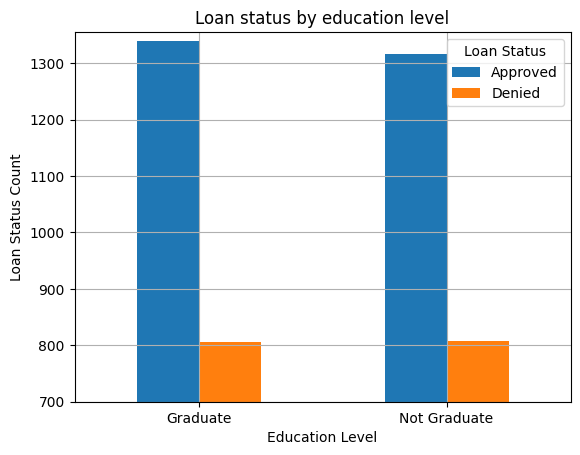

In [10]:
# To analyze the correlation between the education level and loan approval, we groupby these two columns of interest
education_groupby = df.groupby(['undergrad','loan_status'])
# We want to get the count of how many applicants have or do not have undergrad background versus how many were approved or denied for the loan, respectively
# By calling size() on the groupby object, we get the count for the number of elements in "undergrad" and "loan_status". By calling unstack() on the Series,
# we present each element on its own bin separately.
education_count = education_groupby.size().unstack()

# Plot the histogram using Matplotlib

plt.figure(figsize=(9,10))  # The figsize specifies the width and height in inches in a tuple
education_count.plot(kind='bar', stacked = False)  # Create a vertical bar plot
plt.title('Loan status by education level')  # Title the graph as "Loan status by education level"
plt.xlabel('Education Level')  # Label the X axis as "Education Level"
plt.ylabel('Loan Status Count')  # Label the y axis as "Loan Status Count"
plt.legend(title = 'Loan Status', loc = 'upper right', labels = ['Approved', 'Denied'])  # Create a legend in upper right corner to show what each color represents
plt.xticks(rotation = 0)  # Specify that the x-axis tick labels should not be rotated by setting the rotation angle to 0
plt.grid()  # Add grid to the graph for clearer visualization
plt.ylim(700, 1355)  # Setting the limits of y-axis values
plt.show()

From the histogram above, we can see that one's undergrad background does not appear to have significant influence on determining whether his/her loan request would be approved or denied.

Similarly, we can create a histogram graph to demonstrate the correlation between self-employment status and loan approval:

<Figure size 900x1000 with 0 Axes>

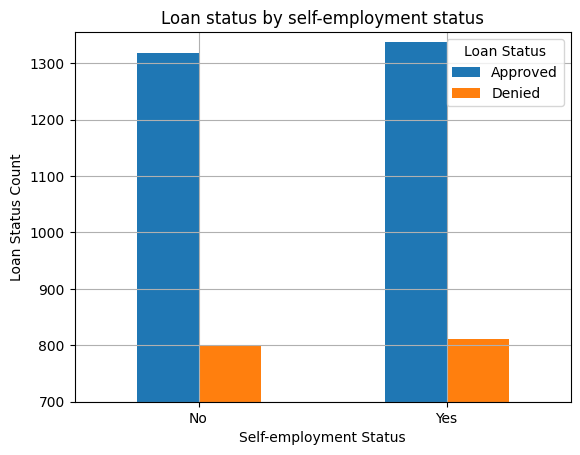

In [11]:
# To analyze the correlation between the self-employment status and loan approval, we groupby these two columns of interest
self_employment_groupby = df.groupby(['self_employed','loan_status'])
self_employment_count = self_employment_groupby.size().unstack()

# Plot the histogram using Matplotlib

plt.figure(figsize=(9,10))  
self_employment_count.plot(kind='bar', stacked = False)  
plt.title('Loan status by self-employment status')  
plt.xlabel('Self-employment Status')  
plt.ylabel('Loan Status Count')  
plt.legend(title = 'Loan Status', loc = 'upper right', labels = ['Approved', 'Denied'])  
plt.xticks(rotation = 0)  
plt.grid()  
plt.ylim(700, 1355)  
plt.show()

As shown in the histogram above, both the approval and denial values are higher for the applicants who responded "Yes" to self-employment status. This appears to make sense as people who are self-employed tend to require more funding to sustain their businesses, though the difference isn't significant when compared to those who are not self-employed. 

Next, we are interested in how credit scores impact the loan approval decisions:

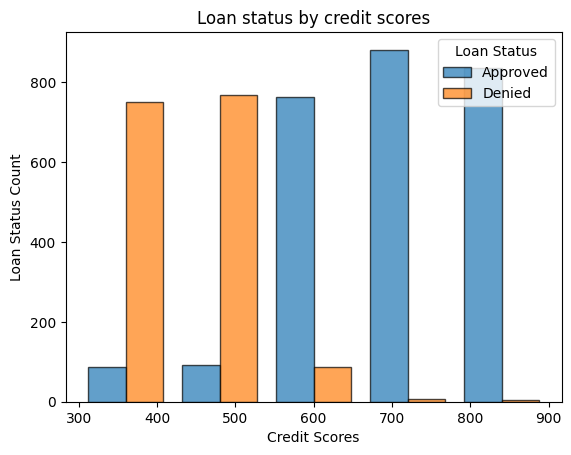

In [12]:
# Separate credit scores based on loan status

approved_scores = df[df['loan_status'] == 'Approved']['credit_score']
denied_scores = df[df['loan_status'] == 'Rejected']['credit_score']

# Plot the histogram for approved and denied loans based on credit scores
plt.hist([approved_scores, denied_scores], bins = 5, edgecolor = 'black', alpha = 0.7, label = ['Approved', 'Denied'])  # create 5 bins for credit scores
plt.xlabel('Credit Scores')
plt.ylabel('Loan Status Count')
plt.title('Loan status by credit scores')
plt.legend(title = 'Loan Status', loc = 'upper right', labels = ['Approved', 'Denied']) 
plt.xticks(rotation = 0)  
plt.show()


As can be observed from the histogram above, as credit scores increase, there is a corresponding increase in the number of approved loans, except for the credit scores above 800, where the number of approved loans dips as there are less applicants with much higher credit scores.

Scatter plots are generally a good way to demonstrate whether there is any correlation between any two given variables. First, we will graph based on "income_annum" and "loan_amount" columns:

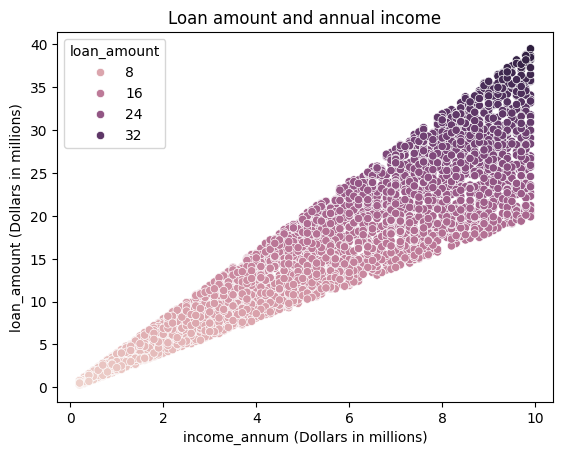

====The coefficients between 'income_annum' and 'loan_amount' is: ====


array([[1.        , 0.92746991],
       [0.92746991, 1.        ]])

In [13]:
# Plot scatter plot between "income_annum" and "loan_amount" using seaborn. Note that "income_annum" data are particularly large, and therefore we will present both "income_annum"
# and "loan_amount" values in millions.
sns.scatterplot(data = df[['income_annum','loan_amount']]/1_000_000, x = 'income_annum', y = 'loan_amount', hue = 'loan_amount')
plt.xlabel('income_annum (Dollars in millions)')
plt.ylabel('loan_amount (Dollars in millions)')
plt.title("Loan amount and annual income")
plt.show()


# Calculate the correlation coefficient between these two variables
print(f"====The coefficients between 'income_annum' and 'loan_amount' is: ====")
display(np.corrcoef(df['income_annum'], df['loan_amount']))

The correlation coefficient of 0.92746991 between "income_annum" and "loan_amount" indicates a significant positive relationship. This implies that individuals with higher incomes typically request larger loan amounts. This aligns logically with the tendency for higher-earning individuals to seek larger investments, such as scaling their businesses on a state or national level. Consequently, these expenses necessitate greater financial support from lending institutions.

Likewise, we can also draw a scatter plot between the "loan_amount" and "residential_assets_value", "commercial_assets_value", "luxury_assets_value", and "bank_asset_value", respectively.

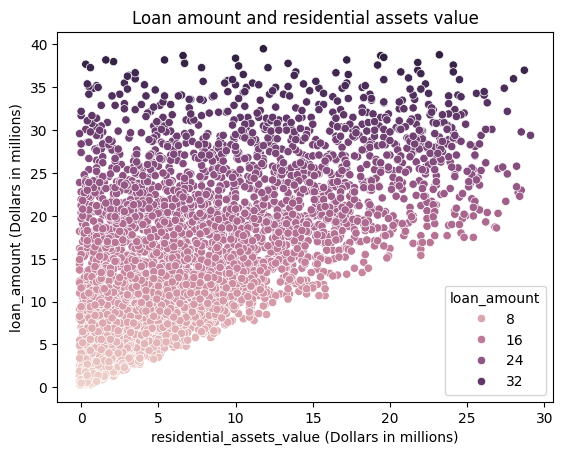

====The coefficients between 'residential_assets_value' and 'loan_amount' is: ====


array([[1.        , 0.59459571],
       [0.59459571, 1.        ]])

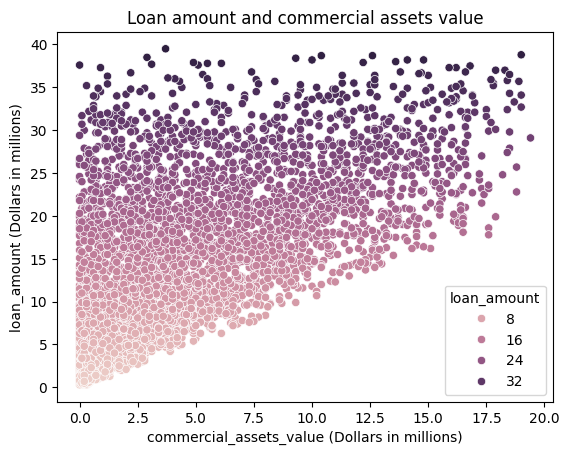

====The coefficients between 'commercial_assets_value' and 'loan_amount' is: ====


array([[1.        , 0.60318809],
       [0.60318809, 1.        ]])

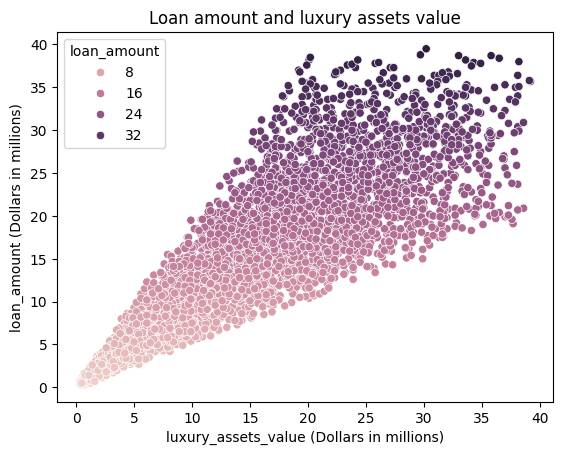

====The coefficients between 'luxury_assets_value' and 'loan_amount' is: ====


array([[1.        , 0.86091403],
       [0.86091403, 1.        ]])

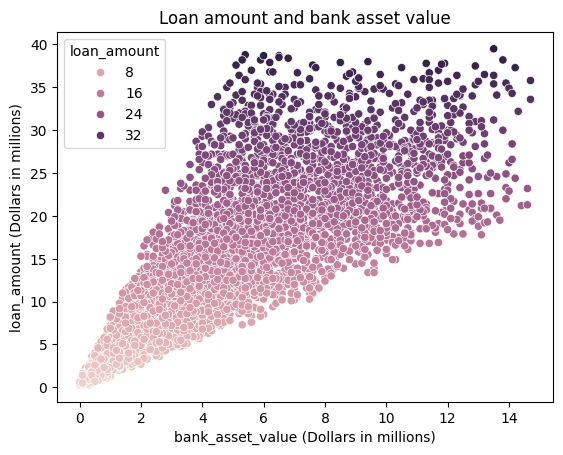

====The coefficients between 'bank_asset_value' and 'loan_amount' is: ====


array([[1.        , 0.78812171],
       [0.78812171, 1.        ]])

In [14]:
# Plot the scatter plot between 'residential_assets_value' and 'loan_amount'. Note that "residential_assets_value" data are particularly large, and therefore we will present both 
# "residential_assets_value" and "loan_amount" values in millions.
sns.scatterplot(data = df[['residential_assets_value','loan_amount']]/1_000_000, x = 'residential_assets_value', y = 'loan_amount', hue = 'loan_amount')
plt.xlabel('residential_assets_value (Dollars in millions)')
plt.ylabel('loan_amount (Dollars in millions)')
plt.title("Loan amount and residential assets value")
plt.show()

# Calculate the correlation coefficient between 'residential_assets_value' and 'loan_amount'
print(f"====The coefficients between 'residential_assets_value' and 'loan_amount' is: ====")
display(np.corrcoef(df['residential_assets_value'], df['loan_amount']))
print("\n")

# Plot the scatter plot between 'commercial_assets_value' and 'loan_amount'. Note that "commercial_assets_value" data are particularly large, and therefore we will present both 
# "commercial_assets_value" and "loan_amount" values in millions.
sns.scatterplot(data = df[['commercial_assets_value','loan_amount']]/1_000_000, x = 'commercial_assets_value', y = 'loan_amount', hue = 'loan_amount')
plt.xlabel('commercial_assets_value (Dollars in millions)')
plt.ylabel('loan_amount (Dollars in millions)')
plt.title("Loan amount and commercial assets value")
plt.show()

# Calculate the correlation coefficient between 'commercial_assets_value' and 'loan_amount'
print(f"====The coefficients between 'commercial_assets_value' and 'loan_amount' is: ====")
display(np.corrcoef(df['commercial_assets_value'], df['loan_amount']))
print("\n")

# Plot the scatter plot between 'luxury_assets_value' and 'loan_amount'. Note that "luxury_assets_value" data are particularly large, and therefore we will present both 
# "luxury_assets_value" and "loan_amount" values in millions.
sns.scatterplot(data = df[['luxury_assets_value','loan_amount']]/1_000_000, x = 'luxury_assets_value', y = 'loan_amount', hue = 'loan_amount')
plt.xlabel('luxury_assets_value (Dollars in millions)')
plt.ylabel('loan_amount (Dollars in millions)')
plt.title("Loan amount and luxury assets value")
plt.show()

# Calculate the correlation coefficient between 'luxury_assets_value' and 'loan_amount'
print(f"====The coefficients between 'luxury_assets_value' and 'loan_amount' is: ====")
display(np.corrcoef(df['luxury_assets_value'], df['loan_amount']))
print("\n")


# Plot the scatter plot between 'bank_asset_value' and 'loan_amount'. Note that "bank_asset_value" data are particularly large, and therefore we will present both 
# "bank_asset_value" and "loan_amount" values in millions.
sns.scatterplot(data = df[['bank_asset_value','loan_amount']]/1_000_000, x = 'bank_asset_value', y = 'loan_amount', hue = 'loan_amount')
plt.xlabel('bank_asset_value (Dollars in millions)')
plt.ylabel('loan_amount (Dollars in millions)')
plt.title("Loan amount and bank asset value")
plt.show()

# Calculate the correlation coefficient between 'bank_asset_value' and 'loan_amount'
print(f"====The coefficients between 'bank_asset_value' and 'loan_amount' is: ====")
display(np.corrcoef(df['bank_asset_value'], df['loan_amount']))


Let's take a close look at the scatter plots above:

1. Residential assets values as well as commercial assets values and loan amounts appear to be weakly related
2. Luxury assets values and loan amounts appear to be strongly related
3. Bank asset values and loan amounts appear to be moderately related

Normally, the residential assets or commercial assets can be used as collaterals for more funding from financial institutions; however, the weak correlations per the first observation indicate that there are other factors at play that could influence the loan amounts. For example, if one has lower income or credit scores, the approved loan value could be low as a result. Further, the property market trends or economic conditions could also impact the perceived future values of the real estate properties in a negative way. 

The second observation seems to align with the first scatter plot between loan amounts and annual income that applicants with higher earnings tend to pursue larger investments.

Lastly, the correlation between bank assets and loan amounts seems reasonable, as higher bank assets suggest a likelihood that an applicant has readily available cash. This liquidity indicates their ability to pay off the loan principal and interest as they come due.

## One-hot Encoding

So far, we have seen that in the dataset, there are both numerical and non-numerical values. The columns containing non-numerical values are called categorical columns (we do not deem that ordinal columns exist in this dataset). However, to use categorical values in regression, we need to first convert them into numerical forms. To achieve that, we will apply the one-hot encoding, which will convert variables into either 0 or 1 values.

In [15]:
# Create a list of the categorical column names to be used in one-hot encoding
categorical_cols = list(df.select_dtypes(include = 'object'))
print(f"categorical columns are: {categorical_cols}")

# Convert the values to either 0 or 1. 1 represents that the value occurred in the data point, whereas 0 means it didn't occur
one_hot_encoded_data = pd.get_dummies(df[categorical_cols], dtype = 'int64')

# Drop 'loan_id' since it won't have meaningful impact on the model 
df = df.drop(columns = ['loan_id'], axis = 1)

# Drop the categorical cols and join the one_hot_encoded_data to avoid duplicative information
df = df.drop(columns = categorical_cols, axis = 1)
df = df.join(one_hot_encoded_data)

print("\n")
display(df.head())

categorical columns are: ['undergrad', 'self_employed', 'loan_status']




,no_of_dependents,income_annum,loan_amount,loan_term,credit_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,undergrad_Graduate,undergrad_Not Graduate,self_employed_No,self_employed_Yes,loan_status_Approved,loan_status_Rejected
0,2,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1,0,1,0,1,0
1,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0,1,0,1,0,1
2,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000,1,0,1,0,0,1
3,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000,1,0,1,0,0,1
4,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0,1,0,1,0,1


## Train Test Split

To develop a model, a dataset is commonly split into train data and test data to train a model and test it on the new data for accuracy rate. Generally, as per the empirical studies, "the best results can be obtained if 20% - 30% of the data are for testing and the remaining 70% - 80 % are for training" (see bibliography for the cited reference below). For this notebook, we will split the data into 80% training and 20% testing. To do this, we will use the train_test_split module from sklearn:

In [16]:
df.columns

Index(['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
       'credit_score', 'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'undergrad_Graduate',
       'undergrad_Not Graduate', 'self_employed_No', 'self_employed_Yes',
       'loan_status_Approved', 'loan_status_Rejected'],
      dtype='object')

In [17]:
# Drop "undergrad_Not Graduate", "self_employed_No", and "loan_status_Rejected" columns since "undergrad_Graduate", "self_employed_Yes", and "loan_status_approved" already 
# contains the related information. More specifically, for any given data entry, if "undergrad_Graduate" column indicates "1", that means the applicant has obtained undergrad
# degree. One cannot have obtained and haven't obtained undergrad degrees at the same time, which would result in a paradox. Therefore, since these columns represent the complete 
# opposite information, we deem only keeping "undergrad_Graduate", "self_employed_Yes", and "loan_status_approved" columns sufficient
df = df.drop(['undergrad_Not Graduate', 'self_employed_No', 'loan_status_Rejected'], axis = 1)
df.rename(columns = {'undergrad_Graduate': 'undergrad', 'self_employed_Yes': 'self_employed', 'loan_status_Approved': 'loan_status'}, inplace = True)

# Divide the data into features (X) and labels (y)
y = df['loan_status']
X = df.drop(['loan_status'], axis = 1)

# Initialize the internal random number generator, which decides the splitting of data into train and test indices
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Logistic Regression

In our case study of loan approval question, it's in essence a classification problem in which we aim to categorize input data into predefined classes or categories ("Approved" vs "Denied" loan status) based on input features ("income_annum", "credit_scores", etc.). To answer this question, we will be applying the Logistic Regression technique imported from sklearn. Please note that linear regression will not be relevant here since it produces continuous output (i.e., temperature throughout the day) instead of discrete output (i.e., animal species like cat, dog, or bird or binary outcomes like "Yes" or "No").

In [18]:
# Instantiate the model using the default parameters
reg = LogisticRegression()

# Fit the model using X_train and y_train data and produce the predictions
reg.fit(X_train, y_train)
predictions = reg.predict(X_test)

# Calculate accuracy by comparing the y_test data and predictions data 
accuracy = accuracy_score(y_test, predictions)
print(f"'Accuracy': {accuracy}")

'Accuracy': 0.6288056206088993


## Concluding Words

From the visual analysis presented earlier, it's evident that credit scores play a pivotal role in determining loan approval. Additionally, income level and luxury asset values exhibit significant correlations with the sanctioned loan amount from financial institutions. Beyond these influential factors, certain elements, such as bank asset values, display a moderate relation with loan amounts. Furthermore, observations based on the histograms indicate that educational background (undergrad) and self-employment status illustrate weaker associations with loan approval. Similarly, the worth of commercial and residential properties also demonstrate mild correlations with sanctioned loan amounts.

Further, we attempted to build a model to predict loan status. The model's performance, as indicated by the accuracy score, shows limitations in accurately predicting loan statuses based on the provided inputs. However, there are various modeling techniques that maybe able to better answer the question: which loan will be approved or denied? The main classification techniques that people use in machine learning are the following:

1. Logistic Regression
2. Decision Trees
3. Random Forest
4. Support Vector Machines
5. Naive Bayes
6. ...

The list goes on. The point here is that although there are limitations on the logistic regression model to generate accurate predictions, there are alternative solutions that can be applied to refine the model, leading to significantly improved accuracy in predictions. Further, as we have seen in the data visualizations above, there are numerous features intricately linked to the approval or rejection of loan applications. Nonetheless, I believe that there exist external factors beyond the scope of this dataset that contribute to the decision-making for loan approval. For instance, it's possible that people residing in disadvantaged areas or impoverished communities face greater challenges in securing loans successfully. Therefore, by incorporating zip code information, we might obtain valuable insights into this facet of the loan approval process. Likewise, the elderly may encounter age biases, and inclusion of age data could potentially unveil whether such biases permeate into the assessment and approval protocols for loans.

## Bibliography

Afshin Gholamy, Vladik Kreinovich, and Olga Kosheleva. Why 70/30 or 80/20 Relation Between Training and Testing Sets: A Pedagogical Explanation. UTEP-CS-18-09. URL: https://scholarworks.utep.edu/cs_techrep/1209/#:~:text=Empirical%20studies%20show%20that%20the,of%20the%20data%20for%20training.